# Imbalanced Data Classification - Banking Customer Churn Prediction 
 
  This goal of this project is to handle the imbalanced classification problem by developing algorithms to identify customers who are likely to churn in the future, interpret results, and give business suggestions.

Methods used: 
- Handling imbalanced classfication problem by stratified sampling and **SMOTE**, which improved ~46% of model performance.
- Chose **recall** as the most suitable metric our business case, achieving best recall of 69.74% by XGBoost

5 most important factors:   
- **Age**: older customer are more likely to churn, especially those who are non-active; opposite is true for younger customers  
-  **NumOfProducts**: customer who used more more than 3 products are more likely to churn; customers who only used 2 products with high account balance are especially likely to churn  
- **Gender**: females are more likely to churn; German females are less likely to churn compared to their those in Spain and France   
- **Geography**: Customer from Germany are more likely to churn, especially those who tried more products;  
- **IsActiveMember**: Non active members are more likely to churn; but younger active members are more likely to churn 
  
Business suggestions: See Part 6
    

# Table of Contents
- [Part 1: Data Exploration](#part1)
- [Part 2: Feature Preprocessing](#part2)
- [Part 3: Model Training and Tuning](#part3)
- [Part 4: Model Evaluation](#part4)
- [Part 5: Feature Importance Discussion](#part5)
- [Part 6: Conclusion](#part6) 

# Part 0 
The bank customer churn [dataset](https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers) is on kaggle.



|Variable name | Description| Type|
|-------| -------| ----- |
|RowNumber |   |Remove|
|CustomerId | | Remove|
|Surname | the surname of a customer has no impact on their decision to leave the bank. |Remove|
|CreditScore | customer bank credit score| continuous|
|Geography | customer location|categorical|
|Gender | customer gender |ordinal|
|Age |customer age|continuous|
|Tenure | number of years that the customer has been a client of the bank. |ordinal|
|Balance | bank account balance. | continuous|
|NumOfProducts | number of products that a customer has purchased through the bank| ordinal|
|HasCrCard | whether or not a customer has a credit card.  (0=No,1=Yes)|ordinal|
|IsActiveMember| (0=No,1=Yes)|ordinal|
|EstimatedSalary| customer salary estimate|continuous|
|Exited | Whether or not the customer left the bank. This is what we have to predict. (0=No,1=Yes)|ordinal|

In [1]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 4.3 MB/s 


In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, make_scorer
import shap
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier 

In [3]:
#https://drive.google.com/file/d/1szdCZ98EK59cfJ4jG03g1HOv_OhC1oyN/view?usp=sharing
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
id = "1szdCZ98EK59cfJ4jG03g1HOv_OhC1oyN"
file = drive.CreateFile({'id':id}) 
file.GetContentFile('bank_churn.csv')

In [4]:
df = pd.read_csv('bank_churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


<a name="part1"></a>
# Part 1 Data Exploration



## 1.1 Understand Raw Dataset

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [6]:
#check errorneous data: we must remove duplicates if exists
if df.duplicated().sum()==0:
    print('no duplicate')

no duplicate


In [7]:
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [8]:
# check missing values
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

- Overview  
The dataset has 10000 observations on 14 variables.  Since the size of data is not very large, we can just use the form of pandas dataframe for this task.  
We can see there's no explicit missing value in original data nor errorneous duplicated data as there're unique CustomerId for each entry. The numercial and categorical variables are in correct dtype as well.  

However, we still need to check if there's any certain value that indicate missing values implicitly in the dataset.  



In [9]:
#descriptive statistics of numerical var
pd.options.display.float_format = '{:.2f}'.format
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.00,5000.50,2886.90,1.00,2500.75,5000.50,7500.25,10000.00
CustomerId,10000.00,15690940.57,71936.19,15565701.00,15628528.25,15690738.00,15753233.75,15815690.00
CreditScore,10000.00,650.53,96.65,350.00,584.00,652.00,718.00,850.00
Age,10000.00,38.92,10.49,18.00,32.00,37.00,44.00,92.00
Tenure,10000.00,5.01,2.89,0.00,3.00,5.00,7.00,10.00
Balance,10000.00,76485.89,62397.41,0.00,0.00,97198.54,127644.24,250898.09
NumOfProducts,10000.00,1.53,0.58,1.00,1.00,1.00,2.00,4.00
HasCrCard,10000.00,0.71,0.46,0.00,0.00,1.00,1.00,1.00
IsActiveMember,10000.00,0.52,0.50,0.00,0.00,1.00,1.00,1.00
EstimatedSalary,10000.00,100090.24,57510.49,11.58,51002.11,100193.91,149388.25,199992.48


In [10]:
#compute zero ratios of covariates
zeros = df[df == 0].count(axis=0)/len(df.index)
print(zeros.sort_values(ascending=False))

Exited            0.80
IsActiveMember    0.48
Balance           0.36
HasCrCard         0.29
Tenure            0.04
RowNumber         0.00
CustomerId        0.00
Surname           0.00
CreditScore       0.00
Geography         0.00
Gender            0.00
Age               0.00
NumOfProducts     0.00
EstimatedSalary   0.00
dtype: float64


We can see that the variable ranges are reasonable, with no negative values, min value is zero (mainly for features with indicator 0), and no missing/null values.

##1.2 Understand the response feature

In [11]:
# get the target variable
y = df['Exited']

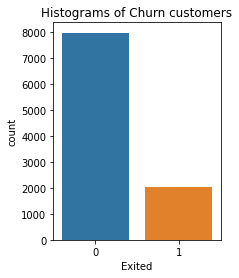

In [12]:
plt.figure(figsize=(3, 4))
sns.countplot(data=df, x='Exited')
plt.title('Histograms of Churn customers')
plt.show()

Here we can see the response label has a very imbalanced distribution. This is a common issue in real life datasets, especially those dealing with customer churn prediction,  anomaly fraud detection, etc. (Anomalies are extreme cases which are not present in our dataset)


Imbalanced data comes with problems such as the following:   
1) common metrics like accuracy may not be suitable to evalute the model;  
2) there may not be enough training samples with negative labels, thus our model will study negative labels and never knows what a positive label is (i.e. dummy classifier that always predicts majority class)


##1.3 Understand numerical features

In [13]:
# numerical features
#['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
#       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
#       'IsActiveMember', 'EstimatedSalary', 'Exited']

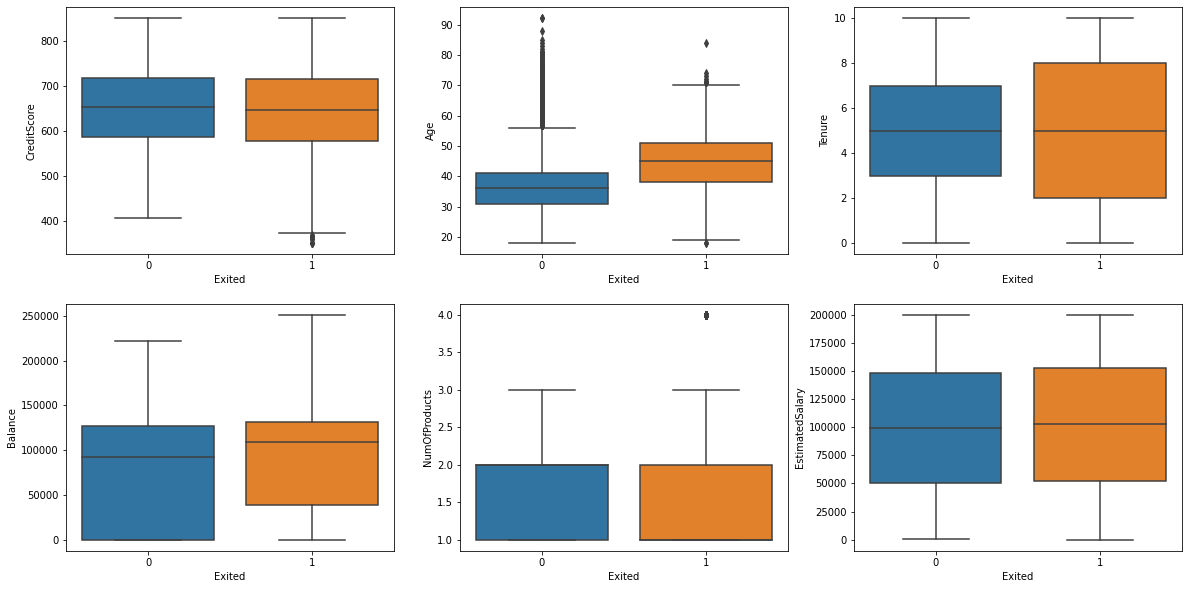

In [14]:
# boxplots for numerical features
_,axss = plt.subplots(2,3, figsize=[20,10])
sns.boxplot(x='Exited', y ='CreditScore', data=df, ax=axss[0][0])
sns.boxplot(x='Exited', y ='Age', data=df, ax=axss[0][1])
sns.boxplot(x='Exited', y ='Tenure', data=df, ax=axss[0][2])
sns.boxplot(x='Exited', y ='Balance', data=df, ax=axss[1][0])
sns.boxplot(x='Exited', y ='NumOfProducts', data=df, ax=axss[1][1])
sns.boxplot(x='Exited', y ='EstimatedSalary', data=df, ax=axss[1][2])
plt.show()


There are six numerical features in the dataset. From the visualizations, we can get some ideas on whether some features are different in distribution between the remained and exited customers. These insights may be important for modeling later.  
1. `Age` for the remained customer seems younger than the exited.
2. The exited seems to have a larger range of `Tenure`, but their mean are about the same. 
3. `Balance` for the remained seems to be lower, especially towards zero end.
4. Other features seem similar between two groups in their boxplots.

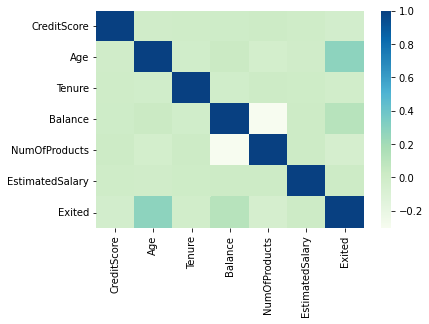

In [15]:
#correlation between features
corr = df[['CreditScore', 'Age',
       'Tenure', 'Balance', 'NumOfProducts',
       'EstimatedSalary', 'Exited']].corr()
sns.heatmap(corr, cmap='GnBu')
plt.show()

In [16]:
#check actual values of correlations
corr

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited
CreditScore,1.00,-0.00,0.00,0.01,0.01,-0.00,-0.03
Age,-0.00,1.00,-0.01,0.03,-0.03,-0.01,0.29
Tenure,0.00,-0.01,1.00,-0.01,0.01,0.01,-0.01
Balance,0.01,0.03,-0.01,1.00,-0.30,0.01,0.12
NumOfProducts,0.01,-0.03,0.01,-0.30,1.00,0.01,-0.05
EstimatedSalary,-0.00,-0.01,0.01,0.01,0.01,1.00,0.01
Exited,-0.03,0.29,-0.01,0.12,-0.05,0.01,1.00


Correlation check can help us identify underlying **multicolinearity problem** that will harm modeling later. Only `Number of Products` and `Balance` appear moderately negatively correlated. With all correlation scores less than 0.5, there's no need to drop feature.  

Note: I also included the response variable `Exited` to see if there are important relationships between explanatory variables and the response variable. It seems that `Age` is the most correlated though its correlation is still weak.


##1.4 Understand categorical features

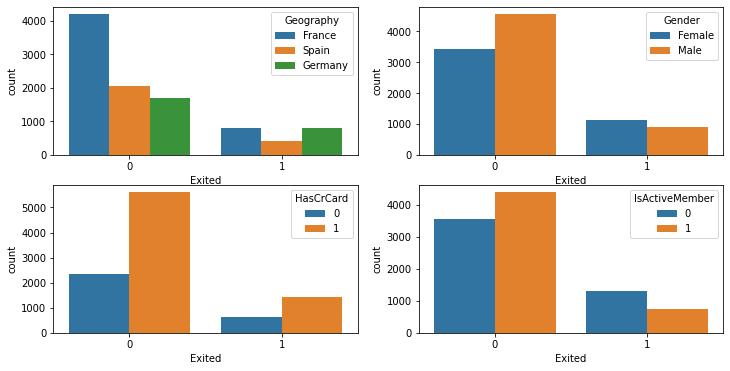

In [17]:
# categorical features:
# 'Geography', 'Gender'
# 'HasCrCard', 'IsActiveMember'
_,axss = plt.subplots(2,2, figsize=[12,6])
sns.countplot(x='Exited', hue='Geography', data=df, ax=axss[0][0])
sns.countplot(x='Exited', hue='Gender', data=df, ax=axss[0][1])
sns.countplot(x='Exited', hue='HasCrCard', data=df, ax=axss[1][0])
sns.countplot(x='Exited', hue='IsActiveMember', data=df, ax=axss[1][1])
plt.show()



There are four categorical features in our dataset. 
1. For `Geography`, the customers in France and Spain have similar distributions between their remained and exited customers; number of customers from France is about two times that of Spain. However customers from `Germany` have a larger portion of exited customers than remained.
2. For `Gender`, the remained have more male than female, while the exited have more `Female`.
3. For `IsActiveMember`, the exited has more non active member while the remained has more active ones.
4. There is similar distribution of `has credit card` or not between the two groups.

<a name="part2"></a>
# Part 2 Feature Preprocessing
In this part, I conducted necessary feature preprocessing for modeling. This includes: 
1. Split train & test set 
1. Encoding categorical features
3. Feature Scaling

The most important thing is to do splitting FIRST before you perform transformation, etc.
The reason is that we want to prevent any **information leakage** from the test set, which is deadly for training process and causes overfitting. 


In [18]:
# Get feature space by dropping useless feature
to_drop = ['RowNumber','CustomerId','Surname','Exited']
X = df.drop(to_drop, axis=1)

In [19]:
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [20]:
X.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
dtype: object

In [21]:
cat_cols = X.columns[X.dtypes=='O']
num_cols = X.columns[(X.dtypes=='float64') | (X.dtypes=='int64')]

##2.1 Split dataset with stratified sampling

I reserve 25% of data for testing and use 75% for training and validation.

I also use **stratified sampling** to ensure similar distributions of label in training and test set. The idea is to keep the training and test data close to the original data, and the assumption is that the population distribution tend to remain the same.  

If we don't use stratified sampling, the splitting will be random across labels. But if classification models use imbalanced data, in extreme case we may end up with ALL positive labels in the train set, and our model biasedly always predicts positive even though our test set has negative observations.
This can **prevent training and evaluating of heterogeneous subgroups (the train and test) which leads to prediction errors**.  


In [22]:
# Reserve 25% for testing
# stratify example:
# 100 -> y: 80 '0', 20 '1' -> 4:1
# 80% training 64: '0', 16:'1' -> 4:1
# 20% testing  16:'0', 4: '1' -> 4:1
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, stratify=y, random_state=1) #stratified sampling

print('Training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' features, \n with churned samples account for ' + str((y_train[y_train==1].count()/len(y_train))*100) + '%')
print('Test data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' features, \n with churned samples account for ' + str((y_test[y_test==1].count()/len(y_test))*100) + '%')

Training data has 7500 observation with 10 features, 
 with churned samples account for 20.37333333333333%
Test data has 2500 observation with 10 features, 
 with churned samples account for 20.36%


##2.2 Encoding categorical features

In [23]:
#convert Geography into dummy variables by OneHotEncoder
# no worry on singularities cuz we use model with regularization
def OneHotEncoding(df, enc, categories):  
  transformed = pd.DataFrame(enc.transform(df[categories]).toarray(), columns=enc.get_feature_names(categories))
  return pd.concat([df.reset_index(drop=True), transformed], axis=1).drop(categories, axis=1)

categories = ['Geography']
enc_ohe = OneHotEncoder()
enc_ohe.fit(X_train[categories])

X_train = OneHotEncoding(X_train, enc_ohe, categories)
X_test = OneHotEncoding(X_test, enc_ohe, categories)


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [24]:
# convert Gender by Ordinal encoding since there're only two outcomes
categories = ['Gender']
enc_oe = OrdinalEncoder()
enc_oe.fit(X[categories])

X_train[categories] = enc_oe.transform(X_train[categories])
X_test[categories] = enc_oe.transform(X_test[categories])

In [25]:
X_train.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,633,1.00,42,10,0.00,1,0,1,79408.17,0.00,0.00,1.00
1,708,0.00,23,4,71433.08,1,1,0,103697.57,0.00,1.00,0.00
2,548,0.00,37,9,0.00,2,0,0,98029.58,1.00,0.00,0.00
3,645,0.00,48,7,90612.34,1,1,1,149139.13,1.00,0.00,0.00
4,729,0.00,45,7,91091.06,2,1,0,71133.12,0.00,0.00,1.00


## 2.3 Feature Scaling
Standardization is to scale the variables to normal distribution. Such tranformation on features with different ranges (or distributions) is a necessity for classification or regression **models that are not tree based** and will be affected by data's original scales. 

There are two most common used scaling method: normalization (eg. MinMaxScaler), which rescales dataset so it falls between [0,1] and StandardScaler, which attempts to transform the dataset into Gaussian distribution. 


I use training data to compute the scaler by StandardScaler, then apply it to both train and test data. A reason I choose **standardization** is that we can easily **interpret coefficients of logistic regressions** with standardized features and 


Feature scaling must be used **after** splitting dataset because we don't want any information leakage from test data and we want to apply the same modification to training and testing data.    

 


In [26]:
scaler = StandardScaler()
scaler.fit(X_train[num_cols])
X_train[num_cols] = scaler.transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [27]:
X_train.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,-0.17,1.00,0.29,1.73,-1.22,-0.91,-1.54,0.97,-0.35,0.00,0.00,1.00
1,0.60,0.00,-1.51,-0.34,-0.08,-0.91,0.65,-1.03,0.07,0.00,1.00,0.00
2,-1.05,0.00,-0.18,1.39,-1.22,0.80,-1.54,-1.03,-0.03,1.00,0.00,0.00
3,-0.05,0.00,0.86,0.70,0.23,-0.91,0.65,0.97,0.87,1.00,0.00,0.00
4,0.82,0.00,0.57,0.70,0.24,0.80,0.65,-1.03,-0.50,0.00,0.00,1.00


<a name="part3"></a>
#Part 3 Model Training and Hyperparameter Tuning 
I implemented several different classfication models in this section for comparing and seeking better performance, including Logistic Regression, Random Forest, XGBoost and KNN.   

I used the following evaluation metrics:

- Accuracy:  proportion of our observations we classify correctly

- Recall (sensitivity, true positive rate): tp / (tp + fn)   
What proportion of the positives in the data are we actually classifying as positive.

- Precision (positive predictive value): tp / (tp + fp)   
What proportion the ones you think are positive, how many are truly positive

- F1 score: 2 \* precision \* recall / (precision + recall)
A balance between precision and recall.

For the business case of our particular problem, I chose **recall score** to refit and pick the optimal model. Recall indicates **how many (in percentage) true customers churned are successfully identified**. Higher recall rate means there is less chance for misidentifying a customer as remained when they actually churned.  This is important as our goal is to identify customer churn for the purpose of **identifying why customers churn and preventing churn**.   Thus, it is not a problem to sacrifice some precision for recall, since the main purpose is to avoid customer churn as much as possible.  



##3.1 Baseline models

In [28]:
#baseline models

# Logistic Regression
classifier_logistic = LogisticRegression(solver='liblinear')
# Random Forest
classifier_RF = RandomForestClassifier(random_state=0, n_jobs = -1)
# XGBoost
classifier_XGB = XGBClassifier(random_state=0, n_jobs = -1)
# K Nearest Neighbors
classifier_KNN = KNeighborsClassifier()

# Use 5-fold Cross Validation to get the recall score for different models
model_names = ['Logistic Regression','Random Forest','XGBoost','KNN']
model_list = [classifier_logistic, classifier_RF, classifier_XGB, classifier_KNN]
count = 0
for classifier in model_list:
    cv_score = model_selection.cross_val_score(classifier, X_train, y_train, scoring='recall',cv=5)
    print(cv_score)
    print('Baseline model recall of ' + model_names[count] + ' is ' + str(cv_score.mean()))
    print()
    count += 1

[0.21967213 0.20655738 0.2254902  0.2124183  0.22875817]
Baseline model recall of Logistic Regression is 0.21857923497267762

[0.51803279 0.47213115 0.46732026 0.46078431 0.4869281 ]
Baseline model recall of Random Forest is 0.4810393228329583

[0.5147541  0.45245902 0.46078431 0.48366013 0.47712418]
Baseline model recall of XGBoost is 0.4777563484410157

[0.41311475 0.42295082 0.38562092 0.4248366  0.43464052]
Baseline model recall of KNN is 0.41623272259723565



We can see that baseline model only achieve highest recall score of 0.48 by XGBoost.

## 3.2 Hyperparameter tuning

Before tuning hyperparameters to find optimal models, I defined several wrapper functions for grid search CV, including a pipeline for SMOTE sampling. I will tune the four models on original data as well and with SMOTE sampled data for comparison.  

[SMOTE (Synthetic Minority Oversampling Technique)](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/) is an oversampling method to handle imbalanced labels. The method oversample on the less observed labels to achieve as many as the more observed labels, so that we have exactly same observations for each class in our dataset. This **increases the predictive power of the model for the minority class** and reduces overfitting issues.


However, an very important point is to **build a pipeline to conduct SMOTE** when we want to include *cross validation* for model training.
It is important to use a pipeline to conduct SMOTE because it avoids leaking the test set into the validation set. It will ensure that we **only oversample on the training set at each iteration**, not both the training and *validation* set. Thus, we should not oversample the whole training set then fit that data to a cross validation function because then oversampling is already performed on *whole* dataset, including *validation fold*.

 


In [29]:
# helper function for printing out Grid Search results  
def print_grid_search_metrics(gs):
    print ("Best score: " + str(gs.best_score_))
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(best_parameters.keys()):
        print('- ' + param_name + ':' + str(best_parameters[param_name]))

In [30]:
# set up multiple evaluation metrics 
scorers = {
    'Accuracy': "accuracy",
    'precision_score': make_scorer(precision_score, zero_division=0),
    'recall_score': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score, pos_label=1)   
}

In [31]:
# wrapper function for conducting grid search
def grid_search(model, xtrain, ytrain, grid, scorers, refit_score='recall_score'):
    '''
    fits a GridSearchCV classifier using refit_score for optimization(refit on the best model according to refit_score)
    '''
    # grid search logistic regression training with 5-fold cross validation
    Grid_cv = GridSearchCV(model, grid, scoring=scorers, refit=refit_score, 
                           cv=5, return_train_score=True)
    Grid_cv.fit(xtrain, ytrain)
    # print the best hyperparameter combination
    print_grid_search_metrics(Grid_cv)
    # plotting the result
    
    return Grid_cv

In [32]:
# wrapper function for conducting grid search with SMOTE oversampling
def grid_search_smote(model, xtrain, ytrain, grid, scorers, refit_score='recall_score'):
    '''
    fits a GridSearchCV classifier using refit_score for optimization(refit on the best model according to refit_score)
    '''
    smote = SMOTE(random_state=0)
    pipeline = Pipeline([
                    ('smote', smote), 
                    ('model', model)
                    ])
    # grid search logistic regression training with 5-fold cross validation
    Grid_cv = GridSearchCV(pipeline, grid, scoring=scorers, refit=refit_score, 
                           cv=5, return_train_score=True)
    Grid_cv.fit(xtrain, ytrain)
    # print the best hyperparameter combination
    print_grid_search_metrics(Grid_cv)
    
    return Grid_cv

In [33]:
#oversample with smote for model with tuned parameters without using pipeline; for downstream use with SHAP in feature importance
def smote_shap(model, xtrain, ytrain):
    smote = SMOTE(random_state=42)
    x_train_sm, y_train_sm = smote.fit_resample(xtrain, ytrain)
    # train model
    clf = model
    clf.fit(x_train_sm, y_train_sm)
    return clf

### Logistic Regression
Two regularization methods for logisitc regression are lasso (l1) and ridge (l2). These methods utilize gradient descent to iteratively find parameters (coefficients) of a function logistic function that minimizes the log loss. Logistic regression has no closed analytical solution which is why it needs gradient descent to minimize loss.

Logistic regression it usually not preferred when data is unbalanced.

In [34]:
grid = {
    'penalty':('l1', 'l2'), 
    'C':(0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 1.1, 1.2)
    }

best_logreg = grid_search(classifier_logistic, X_train, y_train, grid, scorers).best_estimator_

Best score: 0.21857923497267762
Best parameters set:
- C:1
- penalty:l2


In [35]:
# SMOTE
# ignore FutureWarning of function deprecated 
import warnings    
warnings.filterwarnings("ignore")

grid = {
    'model__penalty':('l1', 'l2'), 
    'model__C':(0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 1.1, 1.2)
    }
    
best_logregsm = grid_search_smote(classifier_logistic, X_train, y_train, grid, scorers).best_estimator_

Best score: 0.7552298296367728
Best parameters set:
- model__C:0.001
- model__penalty:l1


### Random Forest
Random forest is an ensemble of decision trees trained on randomly sampled subset of features from training data. Individual decision trees are grown deep and not pruned, thus enabling these trees to have high variance and low bias. For classification, a majority vote is then taken on the predictions made by the ensemble of trees. 

Random forest is usually preferable when the number of features is greater than number of samples or when many complex interactions between features exist.


In [36]:
grid = {
    'n_estimators' : [100,120,140,160],
    'max_depth': [20,40,60]
}

best_rf = grid_search(classifier_RF, X_train, y_train, grid, scorers).best_estimator_

Best score: 0.48692167577413487
Best parameters set:
- max_depth:40
- n_estimators:140


In [37]:
grid = {
    'model__n_estimators' : [160,180,200],
    'model__max_depth': [1,5,10]
}
best_rfsm = grid_search_smote(classifier_RF, X_train, y_train, grid, scorers).best_estimator_

Best score: 0.7009278902817959
Best parameters set:
- model__max_depth:5
- model__n_estimators:180


### XGBoost
XGBoost is also an ensemble method that works by boosting trees. XGboost makes use of a gradient descent algorithm which is the reason that it is called Gradient Boosting. Compared to Random Forest which grow all trees randomly before final aggregation, Gradient Boosing will correct the previous mistake done by the model, learn from its mistakes  improve its performance on the next step.

In [ ]:
grid = {
    'n_estimators' : [40,50,80],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [20,30,40]
}
best_xgb = grid_search(classifier_XGB, X_train, y_train, grid, scorers).best_estimator_

In [ ]:
grid = {
    'model__n_estimators' : [20,40,60],
    'model__learning_rate': [0.01, 0.1, 0.2, 0.4],
    'model__max_depth': [1,2,3]
}
best_xgbsm = grid_search_smote(classifier_XGB, X_train.values, y_train, grid, scorers).best_estimator_

### K Nearest Neighbors
After initilizing a random k, for each example in the training data, the distance is calculated between this and the a test observation. After sorting the ordered collection of distance, the first k entries are chosen and the mode (for classification) is returned for the prediction of this test observation.

In [ ]:
grid = {
    'n_neighbors':[1,3,5,7,9]
}
best_knn = grid_search(classifier_KNN, X_train, y_train, grid, scorers).best_estimator_

In [ ]:
grid = {
    'model__n_neighbors':[12,13,14]
}
best_knnsm = grid_search_smote(classifier_KNN, X_train, y_train, grid, scorers).best_estimator_

<a name="part4"></a>
#Part 4 Model Evaluation
In this part, I wrote wrapper functions to generate confusion matrices for each model's results and print out evluation metric scores. Finally, I create matrices for easy comparison between the four evaluation metric scores, with highlighted highest scores for each metric.

 


In [54]:
# calculate accuracy, precision and recall, [[tn, fp],[]]
def cal_evaluation(classifier, cm, out=False):
    np.seterr(divide='ignore', invalid='ignore')
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0) 
    f1 = 2 * precision * recall / (precision + recall)
    print (classifier)
    if out:
        cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
        print (cmDF)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Precision: %.2f%%" % (precision * 100.0))
    print("Recall: %.2f%%" % (recall * 100.0))
    print('F1 score: %.2f%%' % (f1 * 100))
    print()
    df = {'Accuracy':[accuracy], 'Precision': [precision], 'Recall':recall, 'F1 score':f1, 'Model': classifier}
    return df


# print out confusion matrices
def draw_confusion_matrices(confusion_matricies, out=False, highlight=False):
    # - out: print out raw confusion matrices as dataframe if True; default False.
    # - highlight: print out comparison across models with highlight on highest values
    comparison_df = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 score', 'Model'], )
    class_names = ['Not','Churn']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        dict = cal_evaluation(classifier, cm, out)
        df = pd.DataFrame(dict)
        comparison_df = pd.concat([comparison_df, df], ignore_index = True) 
    if highlight:    
        display(comparison_df.set_index('Model').style.highlight_max(axis=0))


In [55]:
# plot confusion matrices
def plot_conf_mat(cm, ax, title):
    '''Plot a confusion matrix in the specified axes object.'''
    sns.heatmap(data=cm,
                annot=True,
                cmap='Blues',
                annot_kws={'fontsize': 16},
                ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Retained', 'Churned'])

    ax.set_ylabel('True Label')
    ax.set_yticks([0.25, 1.25])
    ax.set_yticklabels(['Retained', 'Churned'])

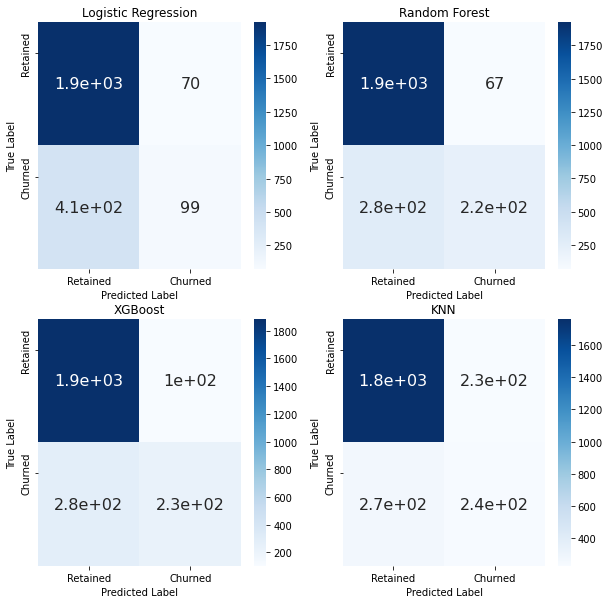

In [56]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(10, 10)) 
titles = ['Logistic Regression', 'Random Forest', 'XGBoost', 'KNN']
axes = [ax1, ax2, ax3, ax4]   
models = [best_logreg, best_rf, best_xgb, best_knn]
# plot normalized confusion matrix
for i in range(4):
    plot_conf_mat(confusion_matrix(y_test, models[i].predict(X_test).round()), axes[i], titles[i])

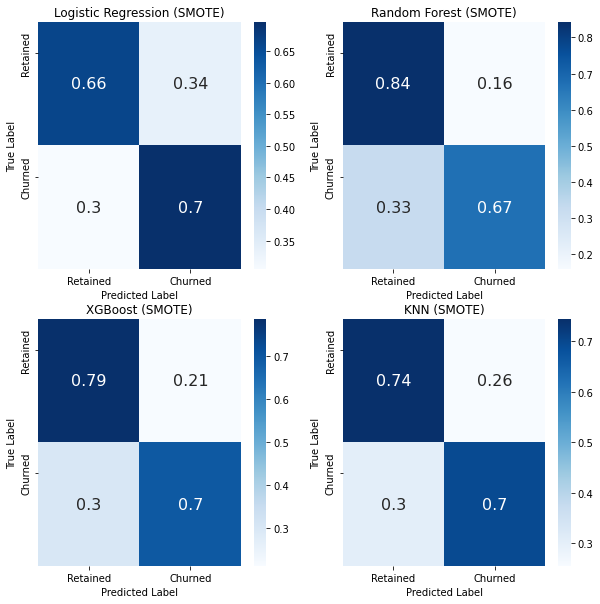

In [178]:
# SMOTE

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(10, 10)) 
titles = ['Logistic Regression (SMOTE)', 'Random Forest (SMOTE)', 'XGBoost (SMOTE)', 'KNN (SMOTE)']
axes = [ax1, ax2, ax3, ax4]   
models = [best_logregsm, best_rfsm, best_xgbsm, best_knnsm]
for i in range(4):
    plot_conf_mat(confusion_matrix(y_test, models[i].predict(X_test.values).round(), normalize='true'), axes[i], titles[i])

In [179]:
# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
# test on x
confusion_matrices = [
    ("Logistic Regression", confusion_matrix(y_test,best_logreg.predict(X_test))),
    ("Random Forest", confusion_matrix(y_test,best_rf.predict(X_test))),
    ("XGBoost", confusion_matrix(y_test, best_xgb.predict(X_test))),
    ("KNN", confusion_matrix(y_test, best_knn.predict(X_test)))
]

draw_confusion_matrices(confusion_matrices, highlight=True)

Logistic Regression
Accuracy: 80.80%
Precision: 58.58%
Recall: 19.45%
F1 score: 29.20%

Random Forest
Accuracy: 85.96%
Precision: 77.05%
Recall: 44.20%
F1 score: 56.18%

XGBoost
Accuracy: 84.68%
Precision: 68.86%
Recall: 45.19%
F1 score: 54.57%

KNN
Accuracy: 80.04%
Precision: 51.07%
Recall: 46.76%
F1 score: 48.82%



,Accuracy,Precision,Recall,F1 score
Model,,,,
Logistic Regression,0.808000,0.585799,0.194499,0.292035
Random Forest,0.859600,0.770548,0.442043,0.561798
XGBoost,0.846800,0.688623,0.451866,0.545670
KNN,0.800400,0.510730,0.467583,0.488205


In [180]:
# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
# test on x
confusion_matrices = [
    ("Logistic Regression (SMOTE)", confusion_matrix(y_test,best_logregsm.predict(X_test))),
    ("Random Forest (SMOTE)", confusion_matrix(y_test,best_rfsm.predict(X_test))),
    ("XGBoost (SMOTE)", confusion_matrix(y_test, best_xgbsm.predict(X_test.values))),
    ("KNN (SMOTE)", confusion_matrix(y_test, best_knnsm.predict(X_test)))
]

draw_confusion_matrices(confusion_matrices, out=True, highlight=True)

Logistic Regression (SMOTE)
        pred_0  pred_1
true_0    1322     669
true_1     155     354
Accuracy: 67.04%
Precision: 34.60%
Recall: 69.55%
F1 score: 46.21%

Random Forest (SMOTE)
        pred_0  pred_1
true_0    1677     314
true_1     167     342
Accuracy: 80.76%
Precision: 52.13%
Recall: 67.19%
F1 score: 58.71%

XGBoost (SMOTE)
        pred_0  pred_1
true_0    1568     423
true_1     154     355
Accuracy: 76.92%
Precision: 45.63%
Recall: 69.74%
F1 score: 55.17%

KNN (SMOTE)
        pred_0  pred_1
true_0    1482     509
true_1     155     354
Accuracy: 73.44%
Precision: 41.02%
Recall: 69.55%
F1 score: 51.60%



,Accuracy,Precision,Recall,F1 score
Model,,,,
Logistic Regression (SMOTE),0.670400,0.346041,0.695481,0.462141
Random Forest (SMOTE),0.807600,0.521341,0.671906,0.587124
XGBoost (SMOTE),0.769200,0.456298,0.697446,0.551671
KNN (SMOTE),0.734400,0.410197,0.695481,0.516035


We can see that using SMOTE in model training and tuning significantly improves model performance! The highest recall achieved by training on original data is only 0.47, but with SMOTE we can achieve up to 0.7

SMOTE models has much better performance so from now on, we will only compare optimal models with SMOTE here.  

While XGBoost has highest recall, the other three models have very similar recall. 

However, Random Forest has the highest values for the other three evaluation metrics. For our business case, XGBoost would be the best model to use since it has the highest recall.


<a name="part5"></a>
#Part 5 Feature Importance Discussion
For the 3 models with better performance, I will first use Gini feature importance to find the relative predictive power of each feature.

However, a **major flaw** of Gini feature importance is it can **give high importance to features that are not predictive of the unseen data** when the model overfits. This means features that are most important are not ranked the highest. Feature importance also fails to mitigate the bias it has towards features that can have high level of distinct values (especially in the case of numerical features). 

Another pitfall we must avoid is the **effect of multicollinearity** on calculation of permutation based feature importance like SHAP. However, we have checked for highly correlated features through exploratory data analysis (Part 1) and found none that would be major issues.

The second feature importance measure I will use is **SHAP**, which makes the model more explainable. Basically, feature values of an individual observation work together to cause a change in the model’s prediction with respect to the model’s expected output and distributes the total change in prediction fairly among the features, reflecting their contributions across all possible subsets of features. Visualizations using SHAP can provide more information on the relationship between features and the response.


I will compare the feature importance for the models (except KNN) to come to a conclusion about what are the final factors in general that are useful for prediction. 
 



 

## XGBoost

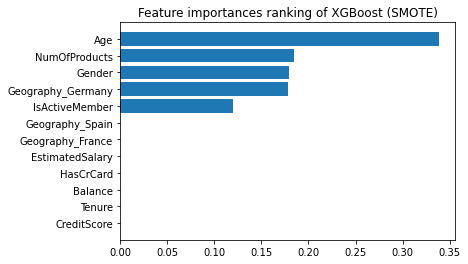

In [181]:
importances = best_xgbsm.named_steps['model'].feature_importances_
indices = np.argsort(importances)[::]
#plot feature ranking
feature_name = X_train.columns.values
plt.barh(feature_name[indices[:X_train.shape[1]]], importances[indices[:X_train.shape[1]]])
plt.title('Feature importances ranking of XGBoost (SMOTE)')
plt.show()

In [182]:
# feature importance ranking
print("Feature importance ranking of XGBoost Model(SMOTE):")
for ind in range(X_train.shape[1]):
  print (" - {0} : {1}".format(X_train.columns[indices[::-1][ind]],round(best_xgbsm.named_steps['model'].feature_importances_[indices[::-1][ind]], 4)))

Feature importance ranking of XGBoost Model(SMOTE):
 - Age : 0.3384999930858612
 - NumOfProducts : 0.1851000040769577
 - Gender : 0.17880000174045563
 - Geography_Germany : 0.17820000648498535
 - IsActiveMember : 0.11940000206232071
 - Geography_Spain : 0.0
 - Geography_France : 0.0
 - EstimatedSalary : 0.0
 - HasCrCard : 0.0
 - Balance : 0.0
 - Tenure : 0.0
 - CreditScore : 0.0


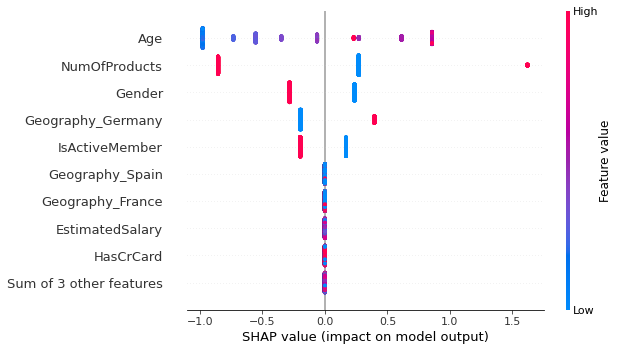

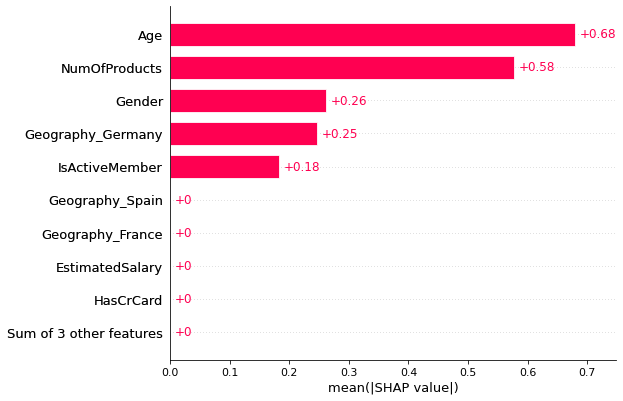

In [198]:
#manual apply SMOTE to optimal model for feeding to SHAP without pipeline
sm_xgb = smote_shap(best_xgbsm[-1], X_train, y_train)
explainer = shap.TreeExplainer(sm_xgb)
shap_values = explainer.shap_values(X_test)
tmp = shap.Explanation(shap_values, data=X_test, feature_names=list(X_train.columns))

#plot SHAP global feature importance 
shap.plots.beeswarm(tmp)
# shap.summary_plot(shap_values, X_test, plot_type='bar')
shap.plots.bar(tmp)

In the first beeswarm plot, there appears to be underfitting by XGBoost model. This may be due to SMOTE sampling (which usually should perform better compared to under-sampling methods that lead to underfitting issues). We will not plot dependence plots for XGBoost results because it will be hard to visualize the interactions among features.

For both Gini feature importance and SHAP, the top five important features are **Age, NumOfProducts, Gender, Geography_Germany**, and **IsActiveMember** in descending order.  

From SHAP, the effect of `Age` and `NumOfProducts` is about two times more than of `Gender`, `Geography_Germany`, 1.4 times more than `IsActiveMember` 
Note: Remember our data has been standardized, so we can directly compare the absolute value of coeffiecients.



## Random Forest

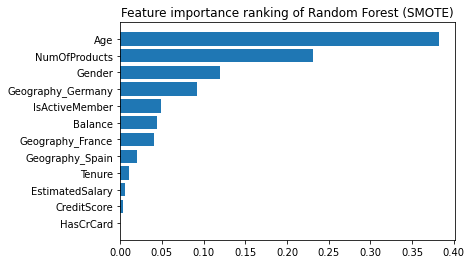

In [186]:
importances = best_rfsm.named_steps['model'].feature_importances_
indices = np.argsort(importances)[::]
#plot feature ranking
feature_name = X_train.columns.values
plt.barh(feature_name[indices[:X_train.shape[1]]], importances[indices[:X_train.shape[1]]])
plt.title('Feature importance ranking of Random Forest (SMOTE)')
plt.show()

In [187]:
# feature importance ranking
print("Feature importance ranking of Random Forest Model (SMOTE):")
for ind in range(X_train.shape[1]):
  print (" - {0} : {1}".format(X_train.columns[indices[::-1][ind]],round(best_rfsm.named_steps['model'].feature_importances_[indices[::-1][ind]], 4)))

Feature importance ranking of Random Forest Model (SMOTE):
 - Age : 0.3822
 - NumOfProducts : 0.2314
 - Gender : 0.1195
 - Geography_Germany : 0.092
 - IsActiveMember : 0.0491
 - Balance : 0.0445
 - Geography_France : 0.0401
 - Geography_Spain : 0.0202
 - Tenure : 0.0105
 - EstimatedSalary : 0.0062
 - CreditScore : 0.0039
 - HasCrCard : 0.0003


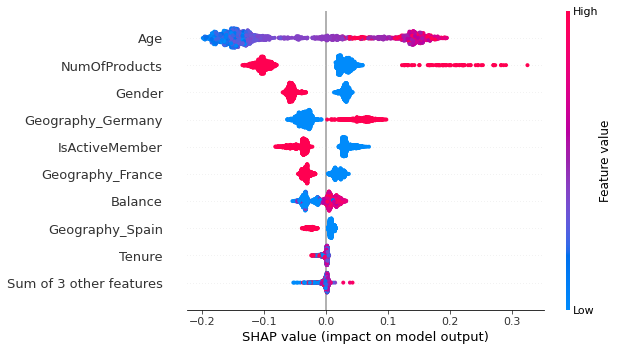

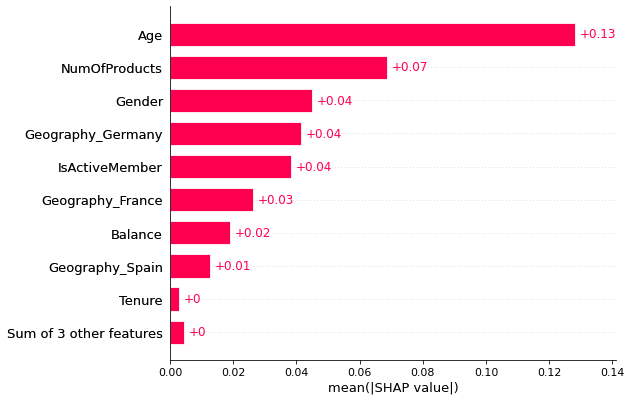

In [200]:
sm_rf = smote_shap(best_rfsm[-1], X_train, y_train)

#plot SHAP global feature importance 
explainer = shap.TreeExplainer(sm_rf)  
shap_values = explainer.shap_values(X_test)
tmp = shap.Explanation(shap_values[1], data=X_test, feature_names=list(X_train.columns)) #shap_values[1] generates explanations with respect to the positive class
shap.plots.beeswarm(tmp)
# shap.summary_plot(shap_values, X_test, plot_type='bar')
shap.plots.bar(tmp)

# shap_vals = explainer(X_test)

In [190]:
# shap_vals = explainer(X_test)
# sex = ["Women" if shap_vals[i,"Gender"].data == 0 else "Men" for i in range(shap_vals.shape[0])]
# shap.plots.bar(shap_vals)

Both Gini feature importance and SHAP produce similar rankings. Random Forest has the same top five important features as XGBoost, which are **Age, NumOfProducts, Gender, Geography_Germany**, and **IsActiveMember** in descending order. Apart from these, Random Forest also has other features that contribute to predictions.  

The effect of `Age` is about two times more than that of `NumOfProducts`, which is about two times more than that of `Gender`, `Geography_germany`, and `IsActiveMember` with the three being similar in scale.  

We can look for explanations of feature contributions using dependence plots below:
 
 


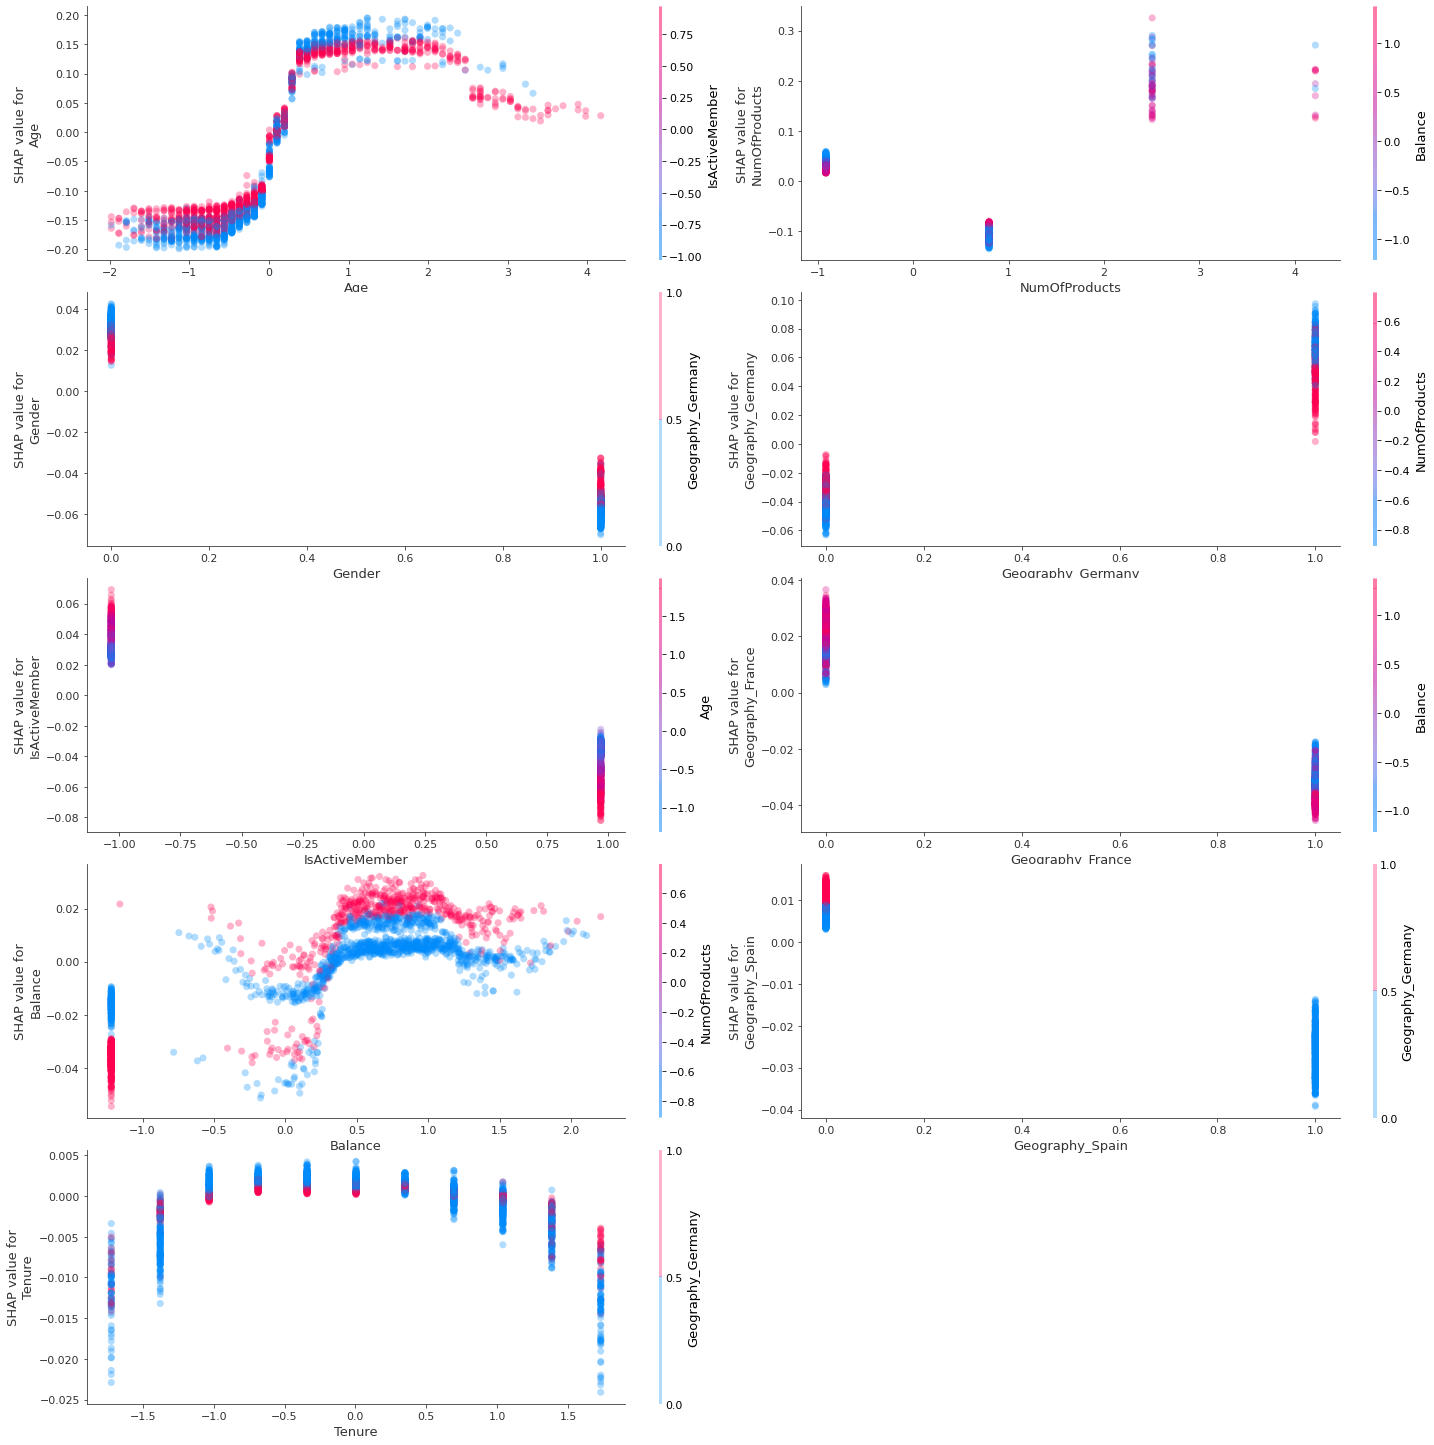

In [206]:
top_features = [ 'Age', 'NumOfProducts', 'Gender','Geography_Germany','IsActiveMember','Geography_France', 'Balance', 'Geography_Spain', 'Tenure']

#Dependence plots
fig, axs= plt.subplots(5, 2, figsize=(20, 15))
fig.delaxes(axs[4,1])
fig.tight_layout()
axs = axs.ravel()
for i, feature in enumerate(top_features):
    shap.dependence_plot(feature, shap_values[1], X_test, ax=axs[i], show=False, dot_size=50, alpha=.3)
    

From `Age` dependence plot, we can see past the average age (~39 years old), customers are significantly more likely to churn. It is important to note there is an interaction between `Age` and `IsActiveMember`. For the older than the average 39 year old customer, customers who are active members are less likely to churn. For younger than average age customer, the opposite is true. Note that especially elderly customers who are active users are also more likely to churn, which may be due to reaching the end of their lives.

For `NumOfProducts`, users of more than 2 products are more likely to churn with users of 2 products being least likely to churn. More specifically, users of 2 products with a high account `Balance` were more likely to churn. Users of 1 product were more likely to churn if their account `Balance` is low, meaning they are trying to see they like the product and comparing it with other companies' products without committing to the bank yet. 

For `Gender`, females were more likely to churn than males. The interaction with `Geography_Germany` shows female customers who were not German are more likely to churn while the opposite is true for males.

For `Geography_Germany`, Germans were more likely to churn than customers from other countries. German customers who tried out more bank products appear to churn more than their counterparts in other countries. 

`IsActiveMember` dependence plot shows young active users are more likely to churn while older non-active users are more likely to churn. 

`Geography_France` users are less likely to churn; French users with high account `Balance` are also less likely to churn compared to their counterparts in other countries.

From the `Balance` dependence plot, we can see more clearly customers with higher than average account balance (~$76485) are more likely to churn if they have used more products.

`Geography_spain` customers were less likely to churn than their counterparts from other countries. 

Customers with around average `Tenure` (~5) plus/minus 1 are most likely to churn. As tenure decreases or increases past average, customers are less likely to churn.
 

## Logistic Regression

In [69]:
indices = np.argsort(abs(best_logregsm.named_steps['model'].coef_[0]))[::-1]
print ("Logistic Regression (SMOTE) Coefficients Ranking")
for ind in range(X_train.shape[1]):
  print ("{0} : {1}".format(X_train.columns[indices[ind]],round(best_logregsm.named_steps['model'].coef_[0][indices[ind]], 4)))

Logistic Regression (SMOTE) Coefficients Ranking
Age : 0.3931
IsActiveMember : -0.0256
Geography_Spain : 0.0
Geography_Germany : 0.0
Geography_France : 0.0
EstimatedSalary : 0.0
HasCrCard : 0.0
NumOfProducts : 0.0
Balance : 0.0
Tenure : 0.0
Gender : 0.0
CreditScore : 0.0


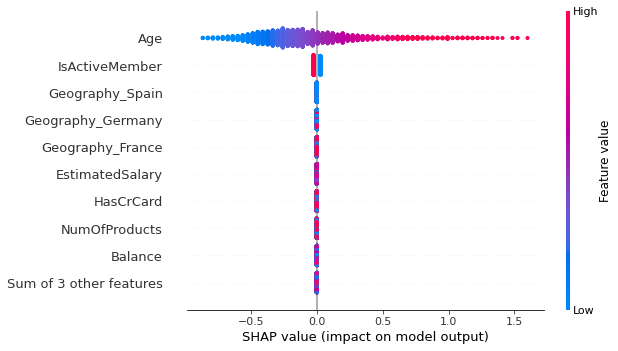

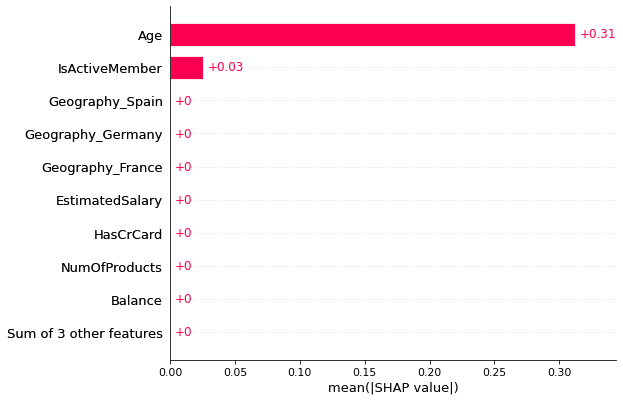

In [213]:
sm_log = smote_shap(best_logregsm[-1], X_train, y_train )

#plot SHAP global feature importance 
explainer = shap.LinearExplainer(sm_log, X_train)
shap_values = explainer.shap_values(X_test)
tmp = shap.Explanation(shap_values, data=X_test, feature_names=list(X_train.columns))
shap.plots.beeswarm(tmp)
# shap.summary_plot(shap_values, X_test, plot_type='bar')
shap.plots.bar(tmp)

# shap_vals = explainer(X_test)
# shap.plots.bar(shap_vals.cohorts(2).abs.mean(0))

For logistic regression(SMOTE), customers who are at the younger end are more likely to stay as customers while the opposite is true for customers at the older end.

Customers who are active members are less likely to churn than non-active members.

Both Gini feature importance and SHAP for Logistic Regression Model (SMOTE) use only two features: **Age** and **IsActiveMember**, with effect of `Age` around 12 times more than that of `IsActiveMember`.


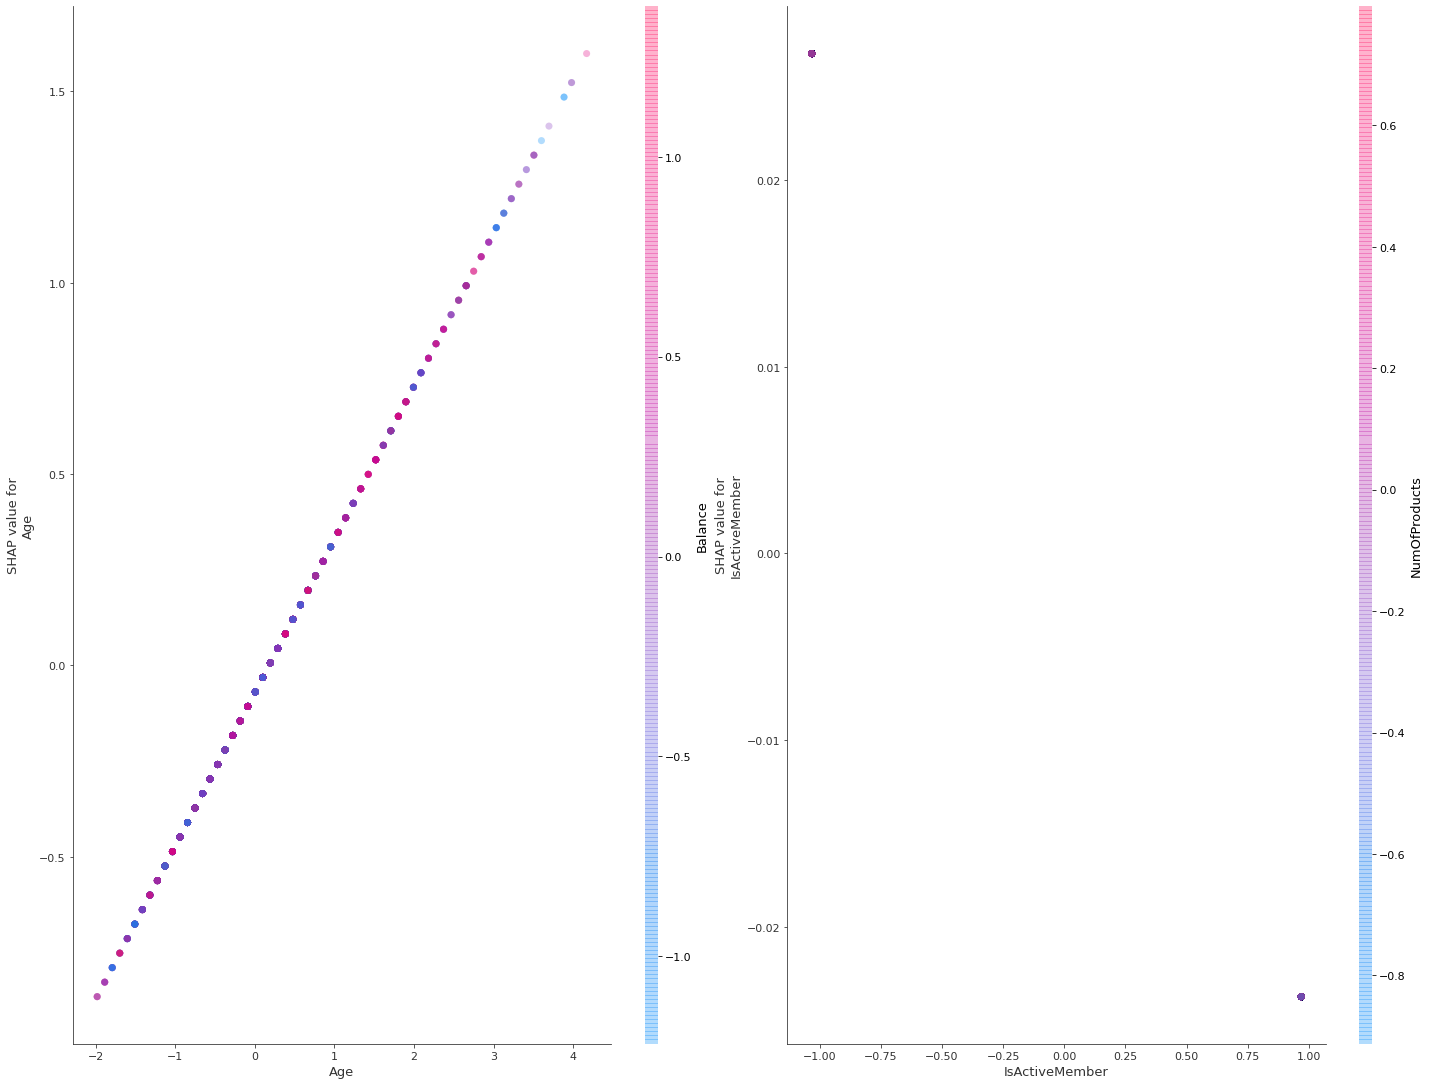

In [214]:
top_features = ['Age', 'IsActiveMember']

#Dependence plots
fig, axs= plt.subplots(1, 2, figsize=(20, 15))
fig.tight_layout()
axs = axs.ravel()
for i, feature in enumerate(top_features):
    shap.dependence_plot(feature, shap_values, X_test, ax=axs[i], show=False, dot_size=50, alpha=.3)

For logistic regression with SMOTE, we can see `Age` has a linear relationship with its SHAP values which implies as customer age increases, the more likely customers will churn. However, the interaction effects between `Age` and `Balance` are a bit difficult to interpret.

<a name="part6"></a>
# Part 6 Conclusion

Summary of Process
- Methods applied:
    - Stratified sampling (to resolve imbalanced data)
    - SMOTE (to resolve imbalanced data)
    - Classification Models: Logistic Regression, Random Forest, XGBoost and KNN
    - Based on our business case, use recall as the evaluation metric for optimizing models

- Workflow:
    - Preprocessed dataset by checking for missing values, removing duplicates, splitting imbalanced data by stratified sampling, encoding categorical feature, and standardizaion
    - Trained, tuned and evaluated classification models with grid search cross validation: applied regularization to logistic regression model and optimal parameters to all models to overcome overfitting.  Resolved imbalanced data effect on prediction results by applying SMOTE sampling technique
    - Selected best model based on recall, achieved best recall of 69.74% with XGBoost, which improved baseline model by 46%
    - Derived feature importance and identified the top factors that influenced the results 



<br>

Main findings:

Based on Gini feature importance and SHAP on  optimal models, we found 5 top factors that influenced customer churn the most: 
1. `Age` is the most important feature.  **Older customer are more likely to churn**. Older customers who are active members are less likely to churn; the opposite is true for younger customers. 
2. `NumOfProducts`: **The more products customers use, the more likely they will churn**. Customers using 2 products are least likely to churn; however among these users, if they have high account `Balance`, they are more likely to churn. The opposites are true for customers with 3 or more products.
3. `Gender`: **Female are more likely to churn**. Females who were not Germans are more likely to churn as opposed to non-German males.
4. `Geography_Germany`: **Customers from Germany** are more likely to churn than customers from Spain or France. German customers who tried more products churned more than their counterparts. 
5. `IsActiveMember`: **Non-active members are more likely to churn** with older segments of non-active members more likely to churn. Younger active members are more likely to churn. 


<a name="part6-suggest"></a>
Main business suggestions:
1. Older customer churn means the bank product failed to meet this customer segment's needs. Especially since non-active older members are more likely to churn, this means although these customers have kept their accounts open, they may also have accounts open at other banks and gradually gravitated towards using them and churned as a result. The **needs of older customers are also different from younger customers**, so it is important to analyze whether the current bank products fits their needs.  
2. Churn customer tend to use more products. Customers who have only used two products and have high account balance are especially likely to churn, which implies they are actively comparing products among companies and picking which is the most suitable for them. There is need for further **investigation on market share** and **competitor analysis** to better understand the situation. However,having deposited significant money in the bank and churning could also be due to bankrupt customers whose accounts are closed down.    
3. Gender may imply different expectations from female than male when it comes to financial product. By research, [95% of German women have their own bank accounts ](https://n26.com/en-de/blog/financial-independence-for-women?fbclid=IwAR15Xk5aqixS4jvxb4I1Iq464VsFJtoadPLvJStAMVnq_AYiBUzOkSFLR_k). Societal differences for women in different countries might affect whether they are able to remain financially independent.
4. High churn in Germany may imply problem related to **powerful local competitors** or **government policies/regulations**. Further research on the competitive landscape in Germany is needed to decide on the causation of churn. 
5. There is need for encouraging (non-active) customers to **engage more on the product**, by nudging them with  seasonal promotions, point rewards program, or more exposure on social media. Again competitive analysis of product offerings is needed to retain the younger active customers who churned.